# Introduction to the ZX-Calculus for Qiskit Practitioners



## Motivations

Of all the sciences, the branch that has arguably developed the most quickly is computer science. One of the most significant reasons for this meteoric rise has been the approachability of the field, afforded to it by abstraction. Today, children can program computers using systems like Scratch without even having to touch their keyboards. Most modern advances in computing, such as efficient machine learning techniques, would certainly have been slowed if computer scientists were still burdened with controlling individual bits. While applications that require such control still remain, for the vast majority of computer scientists and their contributions, intuition and abstraction allows them to create more complex algorithms.

Quantum computing is at a very interesting point in its history. As a field so inherently tied to physics, much of the language used to describe quantum computing relies on physics notation. While this facilitates easier communication between professionals already well-versed in the field, it increases the barrier to entry appreciabily. Consider the most fundamental example of quantum computing notation, describing a statevector as |ψ⟩. It certainly looks cool, but if a layperson saw this, they would immediately assume that it is too complicated for them.

In recent years, quantum circuit notation has become popularized as a more visual way to understand quantum circuits. This notation has many benefits including its potential for abstraction and its vaguely direct analog to physical implementations of the circuit. However, this notation relies on linearity for clarity to the point that it can obfuscate understanding. One cannot immediately see a circuit for, say, the Bell State and understand that it results in an entangled state of (|00⟩+|11⟩)/2. Thankfully, we have a system to ameliorate this issue: the ZX-Calculus.

This notebook tries to help introduce those who may have experience with Qiskit or traditional circuit notation to the ZX-Calculus in the hopes that it will help foster greater intuitive understanding of the processes at play in various quantum algorithms.

## Background

The ZX-calculus uses diagrammatic notation to represent quantum circuits. The most fundamental units of this notation are the vertices. Red vertices indicate a rotation about the X-axis and green vertices indicate a rotation about the Z-axis. If these vertices do not have a value associated with them, they default to a π rotation. These vertices are connected with edges. Traditionally, Hadamard gates are denoted as small squares on edges, but the PyZX library denotes them as blue wires instead. And that's it (at least to understand a circuit).

Now, if we were to simply swap traditional circuit gates with neatly colored vertices and edges, we would not necessarily improve our understanding of the circuit. In fact, in most cases, the circuit would become more complex. Thankfully, the ZX-calculus provides a set of rules to help simplify ZX-diagrams. The most important thing to keep in mind in all of these rules is the dogmatic statement of ZX-calculus: "only connectivity matters".

The rules of ZX-calculus are straightforward and can be found with pictographic explanations: [ZX-Calculus website](https://zxcalculus.com/intro.html) and [ZX-Calculus wikipedia](https://en.wikipedia.org/wiki/ZX-calculus#Generators).

![zx simplification rules](https://www.researchgate.net/publication/346863778/figure/fig4/AS:1021724598468608@1620609535546/ZX-calculus-rules-This-set-of-reversible-axioms-or-rewrite-rules-is-complete-for.png)

Link: https://www.researchgate.net/figure/ZX-calculus-rules-This-set-of-reversible-axioms-or-rewrite-rules-is-complete-for_fig4_346863778


The specifics of these rules are certainly beneficial if understood, but thanks to some abstractions we have developed, one need only understand the end result if they so choose.

One thing to keep in mind is that the ZX-calculus does not consider global phase. This difference cannot be measured, but it could potentially have an effect (it does not affect just about all common algorithms).

## Framework

In [ ]:
# pylatexenc for visualization, pyzx for ZX-calculus, qiskit for everything else
!pip install -q pylatexenc pyzx qiskit # if there is an error, restart the runtime and run again

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import *
import pyzx

In [ ]:
def qiskit_to_pyzx(qc: QuantumCircuit) -> pyzx.Graph:
    """
    Converts a qiskit QuantumCircuit to a pyzx Graph.

    The code is so concise due to the versatility of QASM and qiskit's transpile
    function. QASM (quantum assembly language) is a universal language that can
    help facilitate translation from quantum programming libraries to physical
    systems and other libraries. As such, we can take a quantum circuit from
    Qiskit and convert it to qasm and then pass this into the pyzx library. In
    order for the circuit to be compilable in the ZX-calculus, every gate must
    be an X-rotation or a Z-rotation with the CX-gate to allow for entanglement.
    The transpile function requires a set of basis gates that are universal,
    that is, gates that can be combine to define any arbitrary quantum gate for
    any number of qubit registers. It has been proven that the previously
    mentioned basis gate set is sufficient for this task, and thus, every
    possible circuit can be represented in the ZX-calculus.

    Args:
        qc (QuantumCircuit): the input circuit to convert to a ZX-diagram

    Returns:
        pyzx.Graph: a ZX-diagram representing the input circuit
    """

    return pyzx.Circuit(
        qc.num_qubits
    ).from_qasm(
        transpile(
            qc,
            basis_gates=["x", "z", "rx", "rz", "cx"]
        ).qasm()
    ).to_graph()

In [ ]:
"""
match_functions stores the simplification rules in order (in newer versions of
python, dictionaries maintain order). Each value stores the name of the rule
and the operation itself.
"""
match_functions = {
    pyzx.rules.match_spider: ("Spider fusion", pyzx.rules.spider),
    pyzx.rules.match_ids: ("Identity removal", pyzx.rules.remove_ids),
    pyzx.rules.match_pivot: ("Pivot rule", pyzx.rules.pivot),
    pyzx.rules.match_copy: ("Copy rule", pyzx.rules.apply_copy),
    pyzx.rules.match_bialg: ("Bialgebra rule", pyzx.rules.bialg),
    pyzx.rules.match_lcomp: ("Local complementation", pyzx.rules.lcomp),
    pyzx.rules.match_supplementarity: ("Removal through supplementarity", pyzx.rules.apply_supplementarity)
}

def one_simplification(g: pyzx.Graph, verbose: bool=True) -> bool:
    """
    Simplifies a ZX-diagram as much as possible.

    In each step, iterates through all possible rules and applies the first
    valid simplification.

    Args:
        g (pyzx.Graph): the ZX-diagram to simplify
        verbose (bool): print rules if True

    Returns:
        bool: True if g successfully simplified otherwise False
    """

    pyzx.simplify.to_gh(g)
    for match_function in match_functions:
        valid_matches = match_function(g)
        if len(valid_matches) > 0:
            rule_name, rule_function = match_functions[match_function]
            edges_to_add, vertices_to_remove, _, _ = rule_function(g, valid_matches)
            g.add_edges(edges_to_add)
            g.remove_vertices(vertices_to_remove)
            if verbose:
                print(f"Applied rule: {rule_name}")
            return True
    return False

In [ ]:
def full_simplification(g: pyzx.Graph, verbose: bool=False) -> pyzx.Graph:
    try_again = one_simplification(g, verbose=verbose)
    while try_again:
        try_again = one_simplification(g, verbose=verbose)
    return g

In [ ]:
def qiskit_to_simplified_pyzx(qc: QuantumCircuit) -> None:
    """
    Converts a QuantumCircuit to a simplified ZX-diagram

    While simplifications are possible, executes the next simplification.

    Args:
        qc (QuantumCircuit): the QuantumCircuit to convert and simplify

    Returns:
        pyzx.Graph: a simplified ZX-diagram representing the input circuit
    """

    g = qiskit_to_pyzx(qc)
    g.normalize()
    try_again = one_simplification(g, verbose=False)
    while try_again:
        try_again = one_simplification(g, verbose=False)
    return g

## Examples

### Bell State

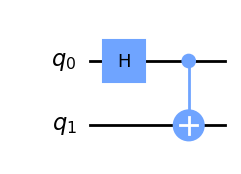

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl", style="clifford")

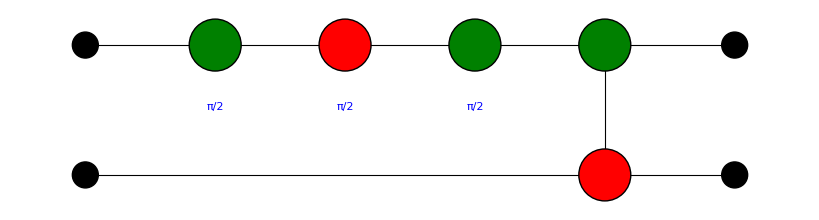

In [ ]:
g = qiskit_to_pyzx(qc)
pyzx.draw_matplotlib(g)

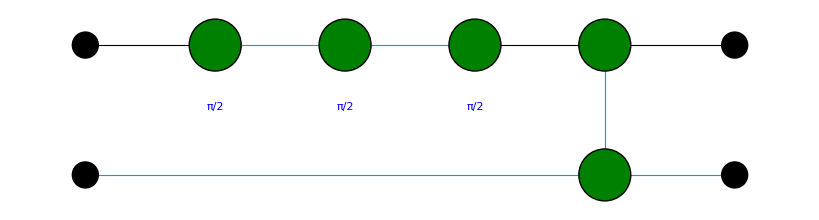

In [ ]:
pyzx.to_gh(g)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


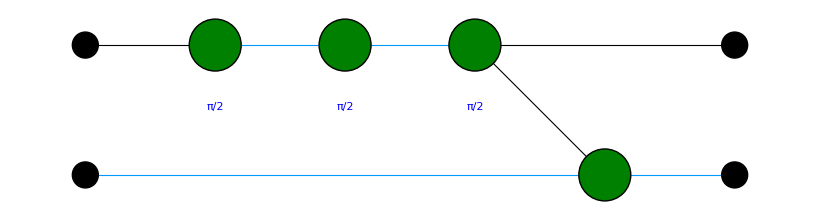

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


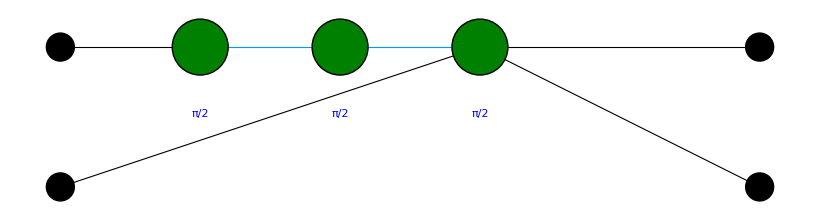

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Local complementation


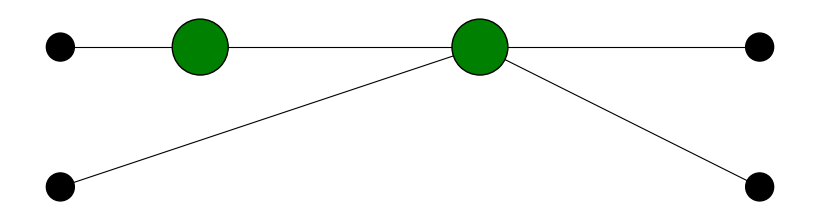

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


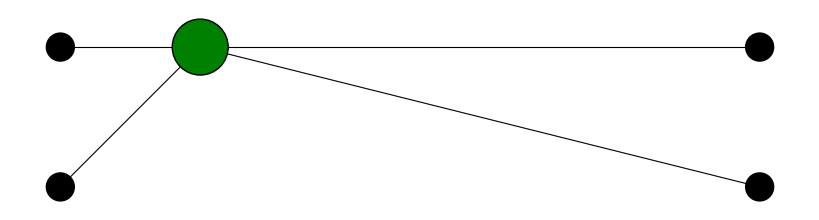

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

### GHZ State

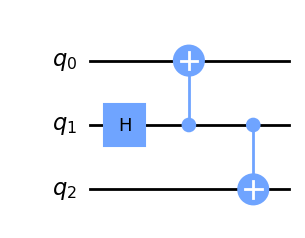

In [ ]:
qc = QuantumCircuit(3)
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.draw("mpl", style="clifford")

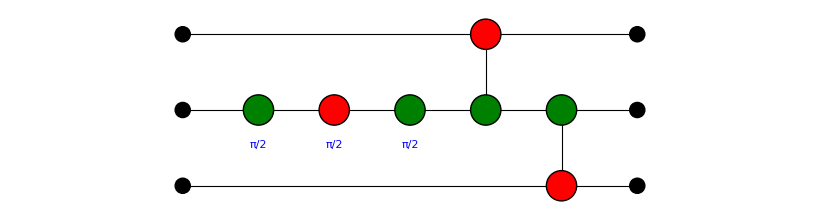

In [ ]:
g = qiskit_to_pyzx(qc)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


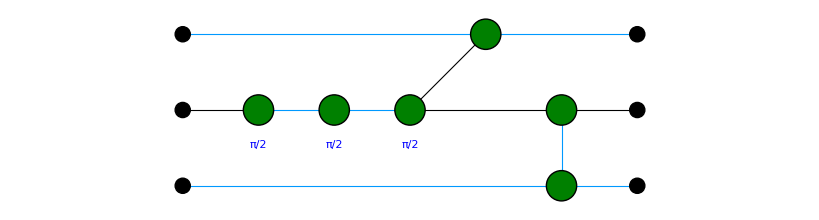

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


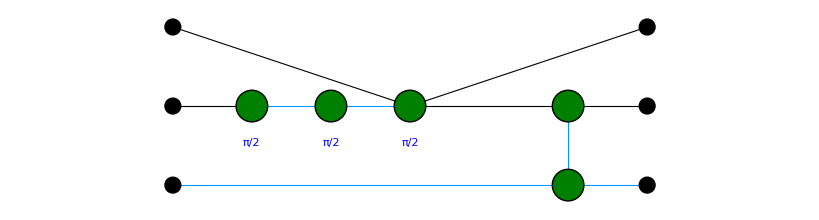

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


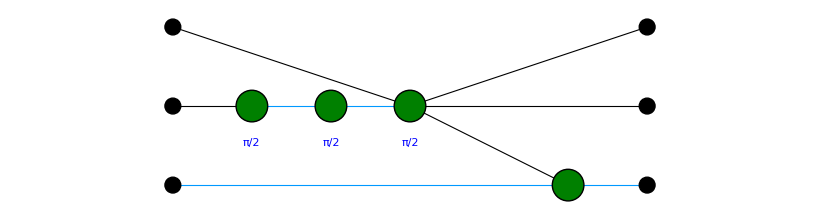

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


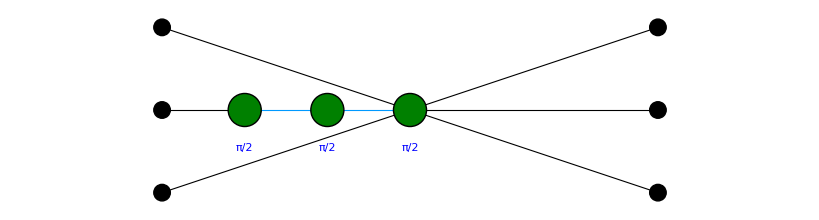

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Local complementation


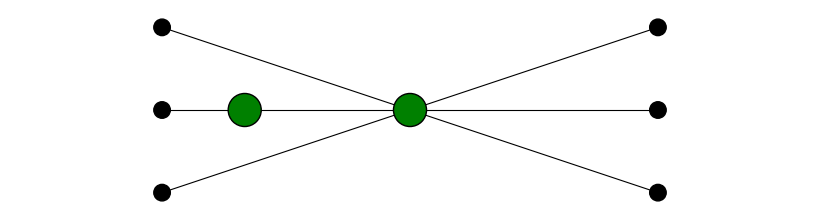

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


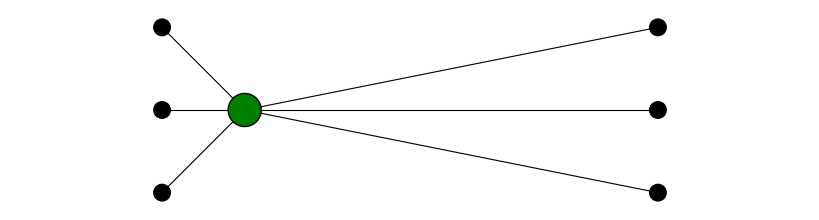

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

### Quantum Fourier Transform

In [ ]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)

    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

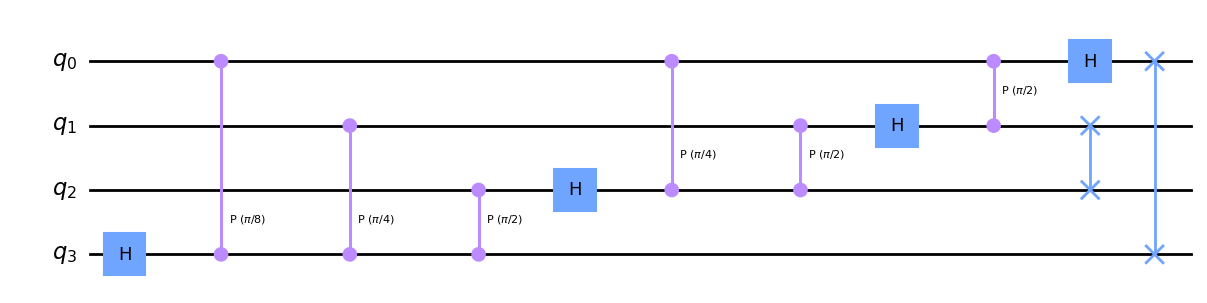

In [ ]:
qc = qft(4)
qc.draw("mpl", style="clifford")

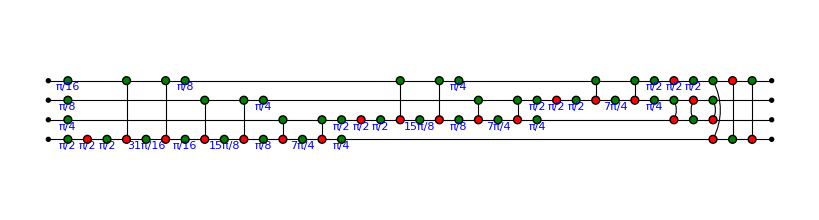

In [ ]:
g = qiskit_to_pyzx(qc)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


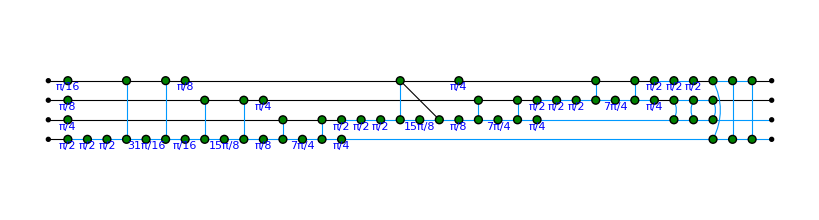

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

Applied rule: Spider fusion


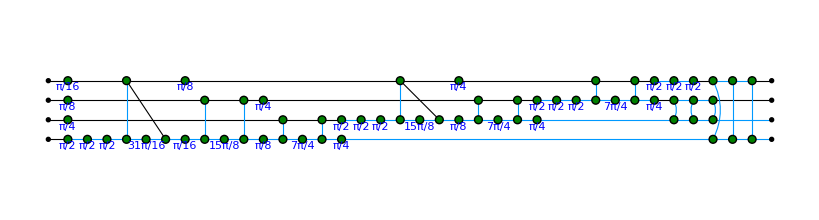

In [ ]:
one_simplification(g, verbose=True)
pyzx.draw_matplotlib(g)

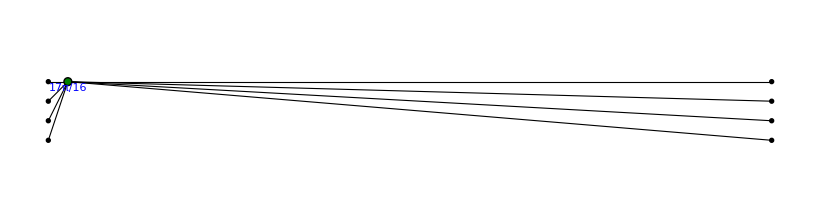

In [ ]:
full_simplification(g)
pyzx.draw_matplotlib(g)

### Quantum Phase Estimation

In [ ]:
def qpe(n):
    qc = QuantumCircuit(n)
    for i in range(n-1):
        qc.h(i)
    qc.x(n-1)
    for counting_qubit in range(n-1):
        for i in range(2**counting_qubit):
            qc.cp(np.pi/4, counting_qubit, n-1)
    qc = qc.compose(qft(n-1).inverse(), list(range(n-1)))
    return qc

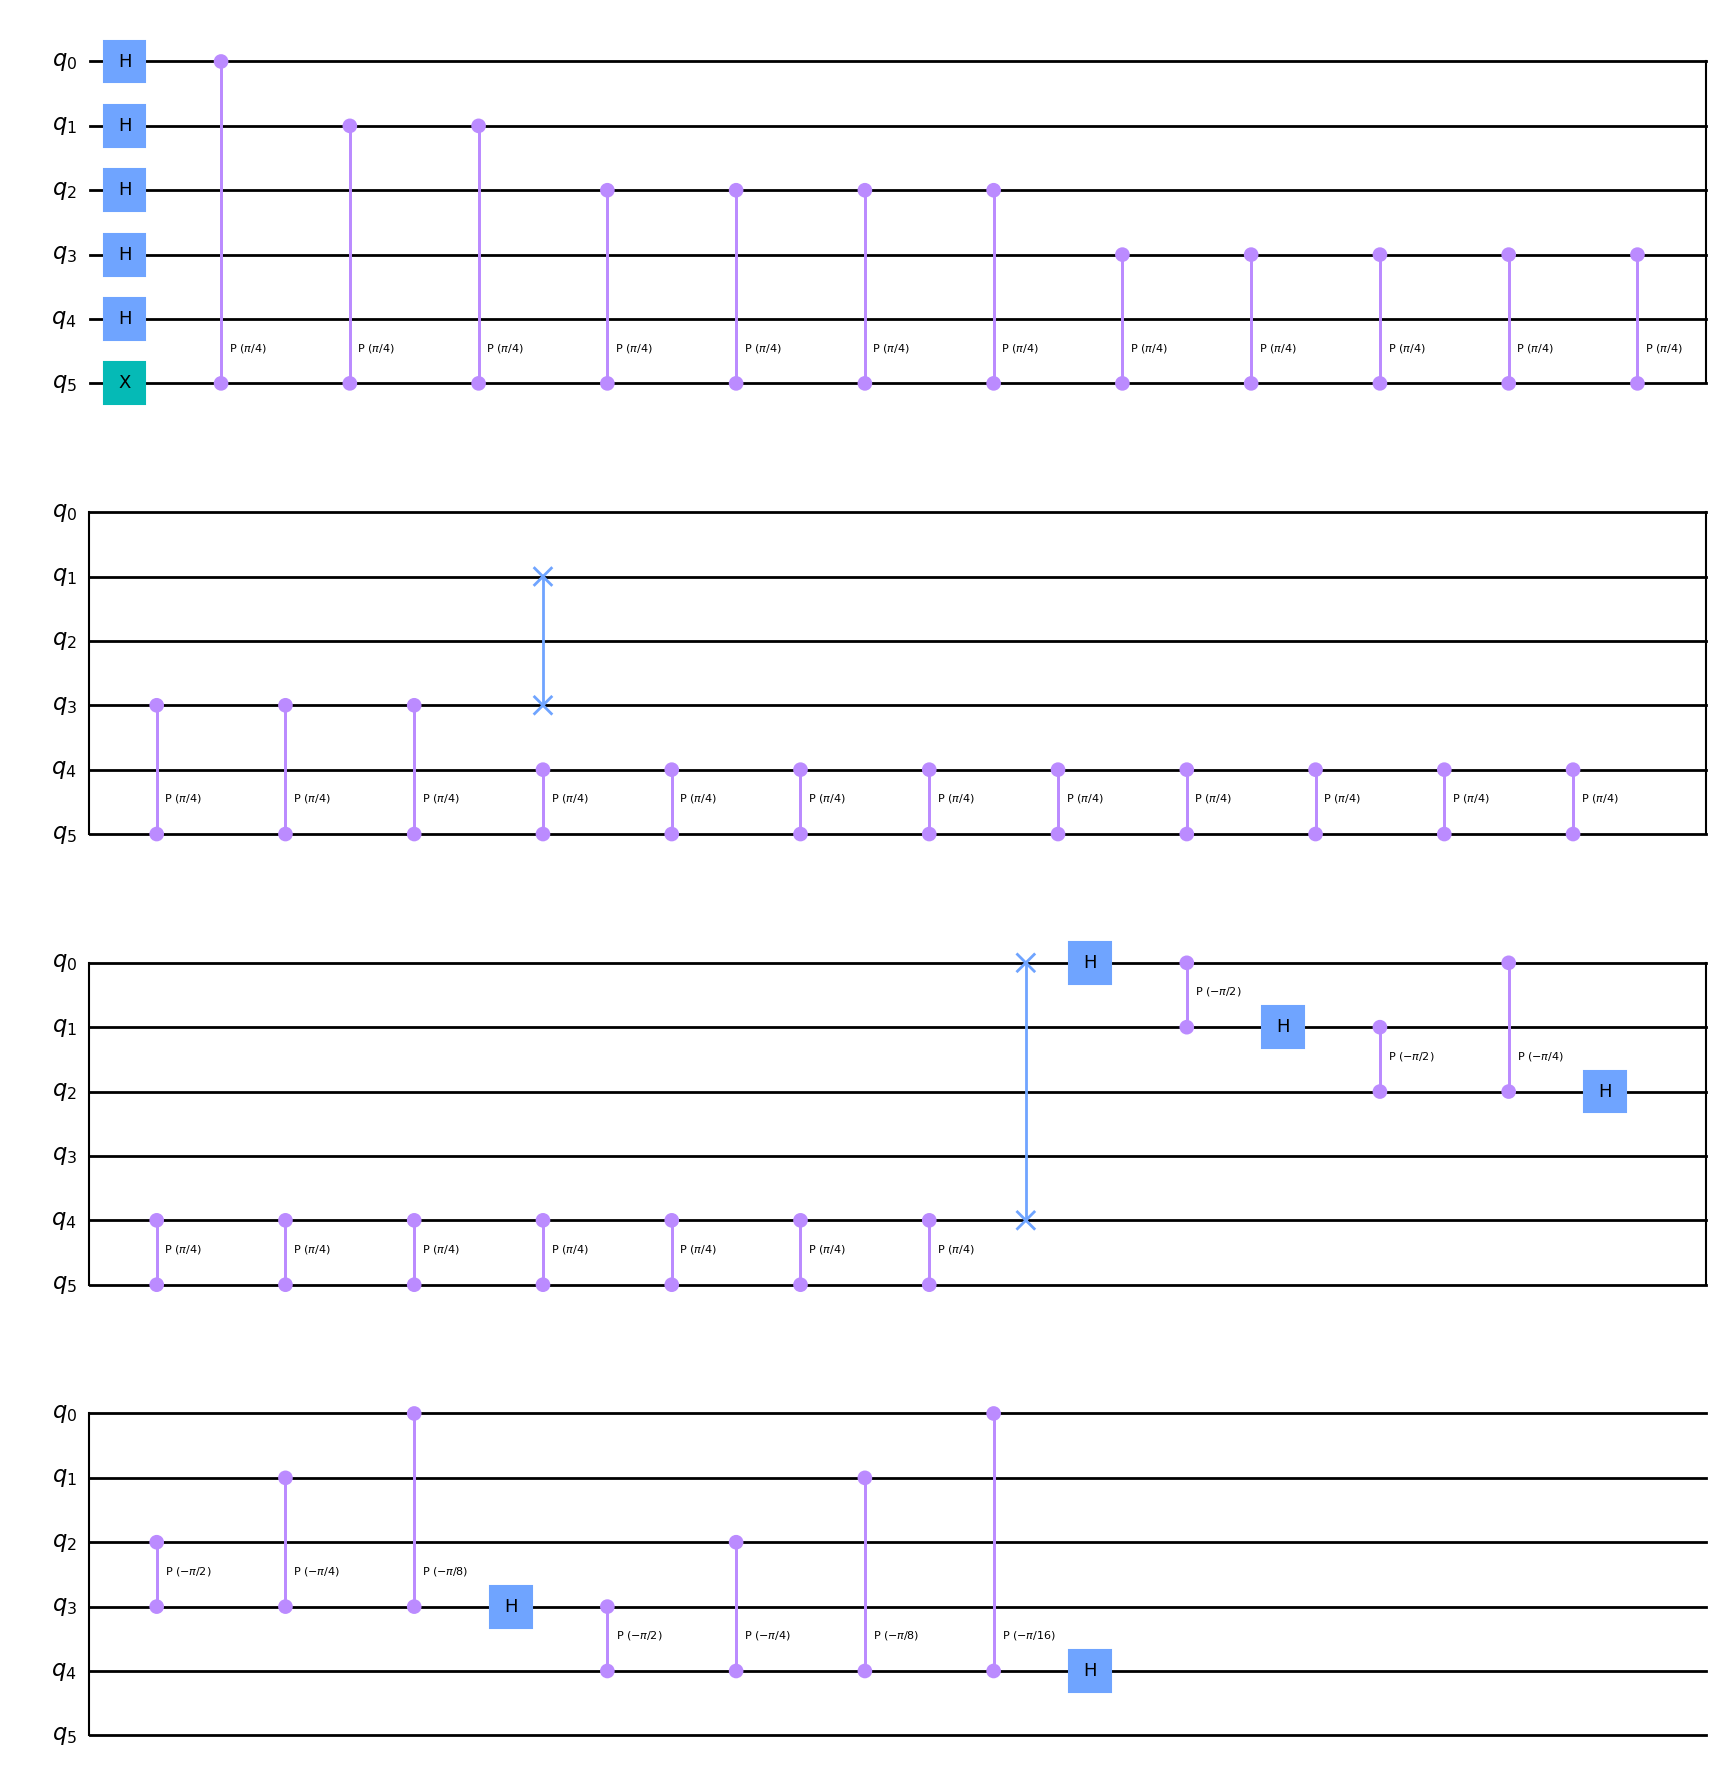

In [ ]:
qc = qpe(6)
qc.draw("mpl", style="clifford")

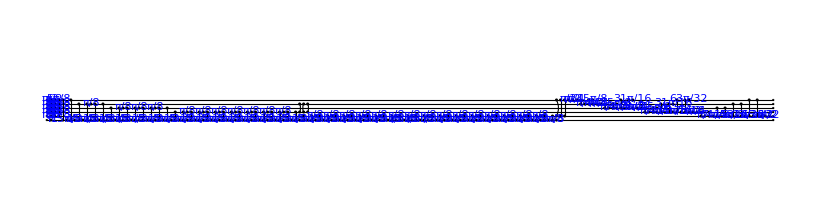

In [ ]:
g = qiskit_to_pyzx(qc)
pyzx.draw_matplotlib(g)

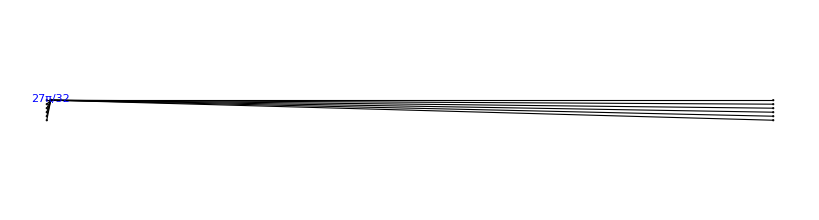

In [ ]:
full_simplification(g)
pyzx.draw_matplotlib(g)

### Deutsch's Algorithm

Deutsch's algorithm determines if the Boolean function is constant or balanced. It offers great reduction in time complexity to solve querying problems.

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


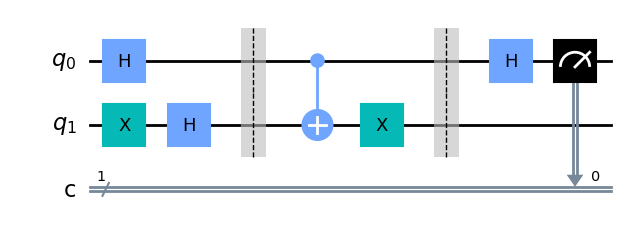

In [ ]:
# Deutsch Function
def deutsch_function(case: int):
    """
    Generate a valid Deutsch function as a `QuantumCircuit`.
    """
    if case not in [1, 2, 3, 4]:
        raise ValueError("`case` must be 1, 2, 3, or 4.")

    f = QuantumCircuit(2)
    if case in [2, 3]:
        f.cx(0, 1)
    if case in [3, 4]:
        f.x(1)
    return f

def compile_circuit(function: QuantumCircuit):
    """
    Compiles a circuit for use in Deutsch's algorithm.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n + 1))

    qc.barrier()
    qc.compose(function, inplace=True)
    qc.barrier()

    qc.h(range(n))
    qc.measure(range(n), range(n))

    return qc

compile_circuit(
    deutsch_function(3)
).draw('mpl')

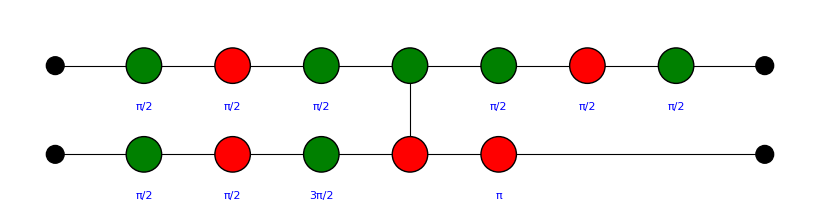

In [ ]:
dc = qiskit_to_pyzx(compile_circuit(deutsch_function(3)))
pyzx.draw_matplotlib(dc)

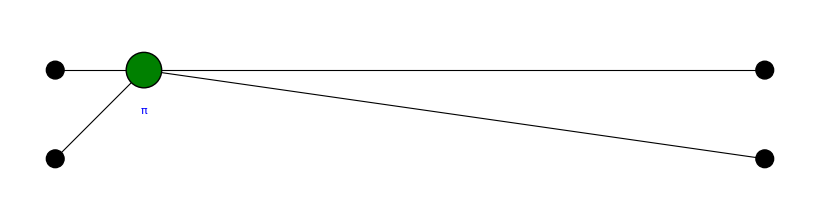

In [ ]:
full_simplification(dc)
pyzx.draw_matplotlib(dc)

### Grover's Algorithm

Grover's algorithm is a very fast quantum search algorithm. The algorithm provides a quadratic speedup for unstructured searches.

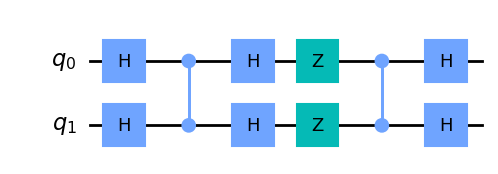

In [ ]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

grover_circuit.cz(0,1)
grover_circuit.draw()

grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw('mpl', style='clifford')

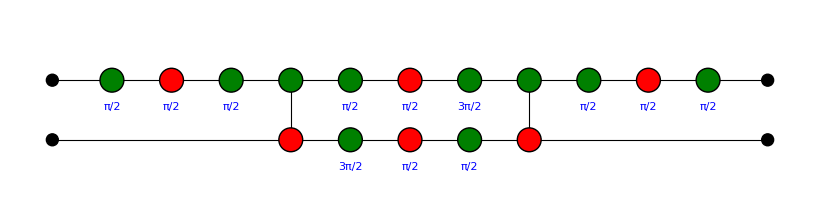

In [ ]:
gc = qiskit_to_pyzx(grover_circuit)
pyzx.draw_matplotlib(gc)

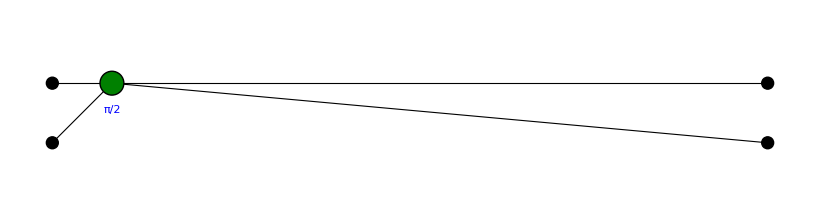

In [ ]:
full_simplification(gc)
pyzx.draw_matplotlib(gc)

## Applications and Future Improvements

Our project boasts a wide array of applications, particularly in integrating qiskit with pyzx. One of its significant advantages lies in education, where the ZX representation of circuits provides a remarkably intuitive view, enhancing the learning experience. For researchers, it streamlines the process of algorithm optimization and aids in general quantum research endeavors.

One major feature to implement is the inclusion of other calculi in quantum computing, including ZH, Z&, and ZW to offer a more complete representation of quantum circuits. In addition, having GPU acceleration would allow faster simplification of complex circuits. Finally, there could be improvements stylistically to the graphs, such as centering the nodes.

## References

• https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

• https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

• https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms

• https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation

• https://pyzx.readthedocs.io/en/latest/index.html

• https://arxiv.org/pdf/2012.13966.pdf

• https://vdwetering.name/pdfs/presentation-pyzx-syco.pdf

• https://github.com/Qiskit/qiskit

• https://github.com/Quantomatic/pyzx

• https://en.wikipedia.org/wiki/ZX-calculus

• https://zxcalculus.com/